In [1]:
import cv2
import numpy as np
from skimage.morphology import skeletonize
import time

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

In [2]:
def rotate_bound(image, angle):
    #function from https://www.pyimagesearch.com/2017/01/02/rotate-images-correctly-with-opencv-and-python/
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
 
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
 
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
 
    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH))


def distance_between(x1,y1,x2,y2):
    dist = np.sqrt((x1-x2)**2+(y1-y2)**2)
    return dist


def get_polynomial_length(poly1d_object,xlims,stepsize=0.5):
    
    xs = np.arange(xlims[0],xlims[1],stepsize)
    ys = poly1d_object(xs)
    length = 0

    for i in range(len(xs)-1):
        length += distance_between(xs[i+1],ys[i+1],xs[i],ys[i])

    return length


def get_nearest_anchor_point(poly1d_object,xlims,point,stepsize=0.5):
    xs = np.arange(xlims[0],xlims[1],stepsize)
    ys = poly1d_object(xs)    
    
    nearest = xs[0]
    prev_dist = distance_between(point[0],point[1],xs[0],ys[0])
    
    for i in range(len(xs)):
    
        dist = distance_between(point[0],point[1],xs[i],ys[i])
        if dist <= prev_dist:
            nearest = xs[i]
    
    newlims = [nearest,xlims[1]]
    
    return newlims


def get_evenly_spaced_points(poly1d_object,xlims,stepsize=10):
    xs = np.arange(xlims[0],xlims[1],1)
    ys = poly1d_object(xs)
    
    xpoints = [xs[0]]
    ypoints = [ys[0]]
    dist = 0
    for i in range(len(xs)-1):
        dist += distance_between(xs[i],ys[i],xs[i+1],ys[i+1])
        if dist>=stepsize:
            xpoints.append(xs[i+1])
            ypoints.append(ys[i+1])
            dist = 0
    
    return (xpoints,ypoints)


def get_end_point(poly1d_object, xlims, distance_to_end, stepsize = 0.1, get_nearest = True):

    xs = np.arange(xlims[0],xlims[1],1)
    ys = poly1d_object(xs)
    
    xpoint = xs[0]
    ypoint = ys[0]
    
    dist = 0
    found_point = False
    
    for i in range(len(xs)-1):
        dist += distance_between(xs[i],ys[i],xs[i+1],ys[i+1])
        if dist >= distance_to_end:
            xpoint = xs[i+1]
            ypoint = ys[i+1]
            
            found_point = True
            break
    
    if get_nearest:
        if not found_point:
            xpoint = xs[-1]
            ypoint = ys[-1]
    
    return [xpoint,ypoint]


def smoothen(data,window):
    w = np.ones(window)/window
    return np.convolve(data,w,'same')

# Input parameters

In [109]:
#videofile = 'sample_300fps.avi'
videofile = '/home/sriram/ncbs/analysis_codes/Fictor_Analysis_Codes/data_temp/bonsai/video_1.avi'
savevid = 'tracking.avi'

outpath = '' 

savevideo = False
savedata = True

tailDirection = 1 # 1,2,3,4 => tail points left, right, up or down respectively in the video frame 
dispFrameInterval = 3 # ms to wait between frames that are displayed
binThresh = 75 # Threshold for binarization. Needs to be adjusted for each fish
polyfit_degree = 5 # Degree of polynomial to fit the contour of the tail
numPoints = 100 # Number of points to describe the tail (for polynomial fitting)
numDisplayPoints = 5 # Number of points to draw on the tail (for illustrative purposes)

manual_anchor = True
clip_end = True

micronsPerPixel = 5 #assumes pixel aspect ratio of 1

#Exercise caution while changing these
claheBlockSize = (2,2)
claheClipLim = 3
medianBlurRadius = 3
gaussianBlurBlockSize = (9,9)


track_length_acceptance_threshold = 0.75
fill_poor_track_with_nans = False

# Background estimation and thresholding

In [5]:
cap = cv2.VideoCapture(videofile)
while not cap.isOpened():
    pass

width = 0
height = 0
if cap.isOpened(): 
    # get cap property 
    width = int(cap.get(3))
    height = int(cap.get(4))
    
    
clahe = cv2.createCLAHE(clipLimit=claheClipLim, tileGridSize=claheBlockSize)

metadata = []
for i in [2,3,4,5,6]:
    md = cap.get(i)
    metadata.append(md)
    print (md)


init = False
if tailDirection == 1 or 2:
    cl1 = np.ones((height,width),np.uint8)*255
else:
    cl1 = np.ones((width,height),np.uint8)*255

while(cap.isOpened()):
    
    ret, frame = cap.read()

    if ret==True:
        
        # Operations to be performed on all frames before tracking begins
        
        if tailDirection == 1:
            frame = rotate_bound(frame,180)
        if tailDirection == 3:
            frame = rotate_bound(frame,90)
        if tailDirection == 4:
            frame = rotate_bound(frame,270)
            
        # 1) Contrast limited adaptive histogram equalization
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        cl1 = clahe.apply(gray)        
        
        # 2) Min projection of the equalized frames
        if not init:
            minProj = cl1
            init = True

        minProj = np.minimum(minProj,cl1)
        
        cv2.imshow('Background Estimation',minProj)

        if cv2.waitKey(dispFrameInterval) & 0xFF == ord('q'):
            break
    else:
        break
        

# Release everything if job is finished
cap.release()
cv2.destroyAllWindows()



# Callback Function for Trackbar
def nothing(*arg):
    pass

def set_threshold(Image, WindowName):
    # Generate trackbar Window Name
    TrackbarName = WindowName + "Trackbar"

    # Make Window and Trackbar
    cv2.namedWindow(WindowName)
    cv2.createTrackbar(TrackbarName, WindowName, 0, 255, nothing)

    # Allocate destination image
    Threshold = np.zeros(Image.shape, np.uint8)

    # Loop for get trackbar pos and process it
    while True:
        # Get position in trackbar
        TrackbarPos = cv2.getTrackbarPos(TrackbarName, WindowName)
        # Apply threshold
        cv2.threshold(Image, TrackbarPos, 255, cv2.THRESH_BINARY, Threshold)
        # Show in window
        cv2.imshow(WindowName, Threshold)

        if cv2.waitKey(5) & 0xFF == ord('q'):
            break

    cv2.destroyAllWindows()
    return TrackbarPos

binThresh = set_threshold(cl1-minProj,'Select Threshold')

0.0033333333333333335
204.0
256.0
300.0
1195724874.0


In [6]:
if manual_anchor:

    #Rough anchor point selection
    # mouse callback function
    def draw_circle(event,x,y,flags,param):
        global start_point
        if event == cv2.EVENT_LBUTTONUP:
            cv2.circle(temp,(x,y),5,(0,0,0),-1)
            start_point = [x,y]

    start_point = [0,0]
    temp = cl1.copy()
    cv2.namedWindow('Select Rough Anchor Point')
    cv2.setMouseCallback('Select Rough Anchor Point',draw_circle)

    while(1):
        cv2.imshow('Select Rough Anchor Point',temp)
        if cv2.waitKey(5) & 0xFF == ord('q'):
            break
    cv2.destroyAllWindows()
    
print('start point = {}'.format(start_point))


if clip_end:

    #Rough anchor point selection
    # mouse callback function
    def draw_circle(event,x,y,flags,param):
        global end_point
        if event == cv2.EVENT_LBUTTONUP:
            cv2.circle(temp,(x,y),5,(0,0,0),-1)
            end_point = [x,y]

    end_point = [0,0]
    temp = cl1.copy()
    cv2.namedWindow('Select Rough End Point')
    cv2.setMouseCallback('Select Rough End Point',draw_circle)

    while(1):
        cv2.imshow('Select Rough End Point',temp)
        if cv2.waitKey(5) & 0xFF == ord('q'):
            break
    cv2.destroyAllWindows()
    
print('end point = {}'.format(end_point))

start point = [26, 130]
end point = [182, 127]


# Tracking algorithm

In [7]:
cap = cv2.VideoCapture(videofile)
    
clahe = cv2.createCLAHE(clipLimit=claheClipLim, tileGridSize=claheBlockSize)

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'MJPG')

if savevideo :

    if tailDirection == 1 or 2:
        out = cv2.VideoWriter(savevid,fourcc, cap.get(5),(width,height))
    else:
        out = cv2.VideoWriter(savevid,fourcc, cap.get(5),(width,height))


polyfit_coeffs = []
xrange = []

motion = []
prevy = []

startTime = time.time()
while(cap.isOpened()):
    
    ret, frame = cap.read()

    if ret==True:
        
        if tailDirection == 1:
            frame = rotate_bound(frame,180)
        if tailDirection == 3:
            frame = rotate_bound(frame,90)
        if tailDirection == 4:
            frame = rotate_bound(frame,270)
        
        # Contrast limited adaptive histogram equalization
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        cl1 = clahe.apply(gray)
        
        #Subtract background
        bgs = cl1-minProj

        blur = cv2.medianBlur(bgs,medianBlurRadius)
        blur = cv2.GaussianBlur(bgs,gaussianBlurBlockSize,0)
        ret2,th = cv2.threshold(blur,binThresh,255,cv2.THRESH_BINARY_INV)
        
        img = 255-th
        img[img>0]=1
        skel = skeletonize(img)
        skel = skel.astype(np.uint8)*100

        if manual_anchor and not clip_end:
            skel[:,0:start_point[0]] = 0
        if manual_anchor and clip_end:
            skel[:,0:start_point[0]] = 0
            skel[:,end_point[0]::] = 0
        if not manual_anchor and clip_end:
            skel[:,end_point[0]::] = 0
        
        x,y = [],[]
        x,y = np.where(skel>0)
        
        z = np.polyfit(y, x, polyfit_degree)
        p = np.poly1d(z)
        polyfit_coeffs.append(z)

        xrange.append([min(y),max(y)])
        xp = np.linspace(min(y), max(y), numPoints)

        points = [[i,j] for i,j in zip(xp,p(xp))]
        
        tempy = p(xp)
        if len(prevy) == 0:
            prevy = tempy
        corr = np.corrcoef(tempy,prevy)[0][1]
        motion.append(corr)
        prevy = tempy
        
        overlay = cv2.cvtColor(cl1, cv2.COLOR_GRAY2BGR)
        cv2.polylines(overlay, np.int32([points]), 0, (0,0,255),1)
        
        if len(xp)<=5:
            drawxp = xp
        else:
            drawxp = xp[0::int(np.ceil(len(xp)/numDisplayPoints))]
                    
        for i in range(len(drawxp)):
            cv2.circle(overlay,(int(drawxp[i]),int(p(drawxp[i]))), 3, (0,255,255), -1)
            
        #overlay = cl1.astype(np.uint8)+skel
        if savevideo:
            out.write(overlay)
        
        cv2.imshow('Tail Tracking',overlay)
        
        if cv2.waitKey(dispFrameInterval) & 0xFF == ord('q'):
            break
    else:
        break

elapsedTime = time.time() - startTime

print('Reconstruction Completed in {}s at {}fps'
      .format(round(elapsedTime,2),(round(len(polyfit_coeffs)/elapsedTime,2))))

# Release everything if job is finished
cap.release()
if savevideo:
    out.release()
    
cv2.destroyAllWindows()

Reconstruction Completed in 1756.26s at 114.42fps


In [8]:
num_subsample = 2000

xapts = []
yapts = []

if len(polyfit_coeffs) <= num_subsample:

    for i in range(len(polyfit_coeffs)):
        polyfit_object = np.poly1d(polyfit_coeffs[i])
        xapt = xrange[i][0]
        yapt = polyfit_object(xapt)
        xapts.append(xapt)
        yapts.append(yapt)
        
else:
    
    for i in range(num_subsample):
        polyfit_object = np.poly1d(polyfit_coeffs[i])        
        xapt = xrange[i][0]
        yapt = polyfit_object(xapt)
        xapts.append(xapt)
        yapts.append(yapt)
        
    
anchor = [np.median(xapts),np.median(yapts)]


cropped_xlims= []
plengths = []

for i in range(len(polyfit_coeffs)):

    polyfit_object = np.poly1d(polyfit_coeffs[i])
    
    crp_lim = get_nearest_anchor_point(polyfit_object,xrange[i],anchor,stepsize=1)
    cropped_xlims.append(crp_lim)
    
    plen = get_polynomial_length(polyfit_object,crp_lim,stepsize=1)
    plengths.append(plen)
        
    
if len(plengths) <= num_subsample:
    tail_length = np.median(plengths[0:num_subsample])
else:
    tail_length =  np.median(plengths)

# Quality check

## Change parameters and track again if tracking fails too frequently

1.08% of frames are tracked poorly
38.77% of all frames are motion frames
2.58% of motion frames are tracked poorly


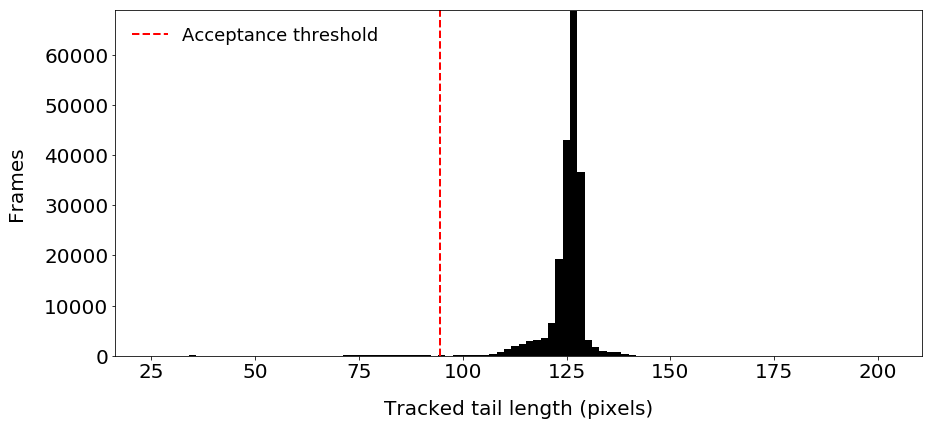

In [42]:
length_threshold = track_length_acceptance_threshold*tail_length

num_low_quality_frames = len(np.where(np.array(plengths) < length_threshold)[0])

lq_fraction = 100*num_low_quality_frames/len(plengths)

print('{}% of frames are tracked poorly'.format(round(lq_fraction,2)))

motion_thresh = 0.05
smooth_motion = 1 - smoothen(motion,20)
motion_frames = np.where(np.array(smooth_motion) > motion_thresh)[0]
num_motion_frames = len(motion_frames)

print('{}% of all frames are motion frames'.format(round(100*num_motion_frames/len(plengths),2)))

mplengths = [plengths[x] for x in motion_frames]

lq_motion_tracks = len(np.where(np.array(mplengths) < length_threshold)[0])

lq_motion_fraction = 100*lq_motion_tracks/num_motion_frames

print('{}% of motion frames are tracked poorly'.format(round(lq_motion_fraction,2)))


fig = plt.figure(figsize=[14,6])
ax = fig.add_axes([.15,.15,.8,.8])

hist = ax.hist(plengths, range=[tail_length*0.2,tail_length*1.6], bins=100, color='black')
ax.vlines(length_threshold,0,max(hist[0])+100, linestyle = '--', linewidth = 2, color = 'red', 
          label = 'Acceptance threshold')

ax.set_xlabel('Tracked tail length (pixels)', fontsize = 20, labelpad = 18)
ax.set_ylabel('Frames', fontsize = 20, labelpad = 18)

ax.set_ylim(0,max(hist[0]+100))

ax.legend(frameon=False, fontsize=18, loc='upper left')

# Get end points

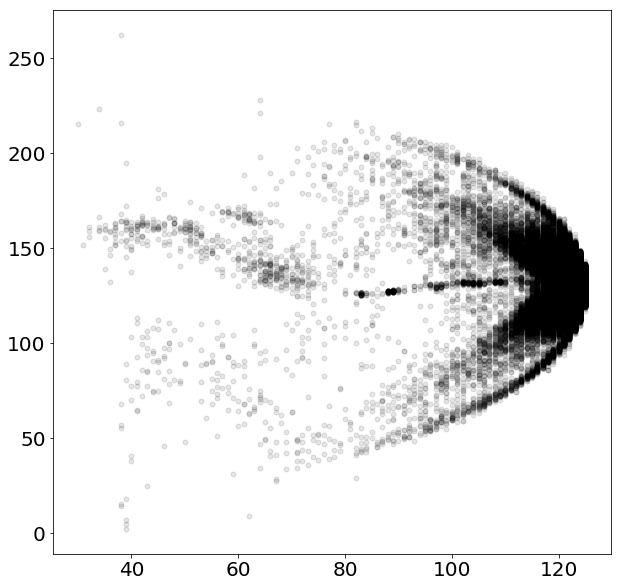

In [110]:
endPoints = [[],[]]
for i in range(len(polyfit_coeffs)):
    
    polyfit_object = np.poly1d(polyfit_coeffs[i])
    
    ep = get_end_point(polyfit_object, [anchor[0], cropped_xlims[i][1]], 
                       length_threshold, stepsize = 0.5)
    
    
    if fill_poor_track_with_nans:
    
        if plengths[i] < length_threshold:
            endPoints[0].append(np.nan)
            endPoints[1].append(np.nan)

        else:     
            endPoints[0].append(ep[0])
            endPoints[1].append(ep[1])
            
    else:
        endPoints[0].append(ep[0])
        endPoints[1].append(ep[1])
    
    
plt.figure(figsize=[10,10])
plt.scatter(endPoints[0],endPoints[1], s=25, color='black', alpha=0.1)

# Save tracking data

In [111]:
keys = ['numFrames', 'lengthThreshold', 'accpetanceThreshold', 
        'poorlyTrackedFrames', 'motionFrames', 'poorlyTrackedMotionFrames']

values = [len(plengths), length_threshold, track_length_acceptance_threshold, 
          lq_motion_fraction, 100*num_motion_frames/len(plengths), lq_motion_fraction] 

metrics = dict(zip(keys,values))

if savedata :    
    np.savez(outpath+'trackdata.npz', polyfit_coeffs = polyfit_coeffs, endPoints = endPoints, metrics = metrics)